# Домашнее задание по теме «Улучшение качества модели»

***Цель:***  
Взять boston house-prices datase (sklearn.datasets.load_boston). Обучить 7 любых регрессоров (попробовать разные алгоритмы, поподбирать параметры, вывести итоговое качество).

***План:***
1. Загрузка и изучение датасета
2. Построение моделей, перебор гиперпараметров и сравнение результатов
3. Выводы по работе

### Шаг 1. Загрузка и изучение данных

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [47]:
from sklearn.datasets import load_boston
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.stochastic import sample
from hyperopt import rand, tpe
from functools import partial
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [49]:
houses = pd.read_csv(load_boston()['filename'], skiprows=1)
houses

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [50]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Данные нам знакомы из прошлого домашнего задания. Пропусков там нет, но есть большие выбросы в столбцах "CRIM" и "ZN". Посмотрим снова на них:

In [51]:
houses.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Пропусков нет. Довольно большая дисперсия в колонке 'CRIM' и 'ZN'.  
Тем не менее посмотрим на все колонки сразу:

Boxplot CRIM


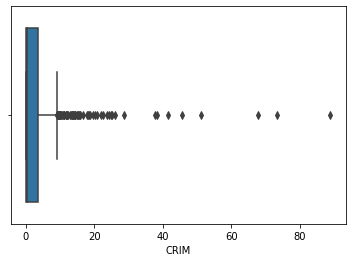

Distplot CRIM


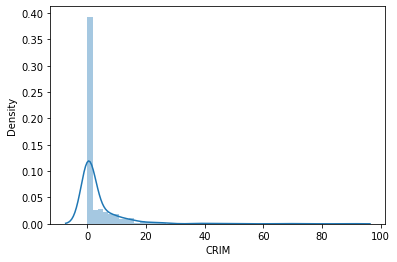

Boxplot ZN


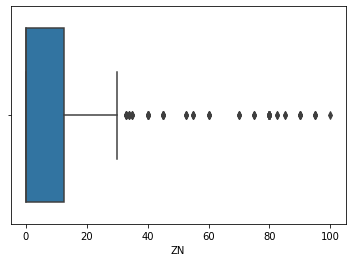

Distplot ZN


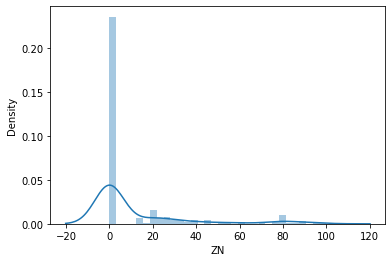

Boxplot INDUS


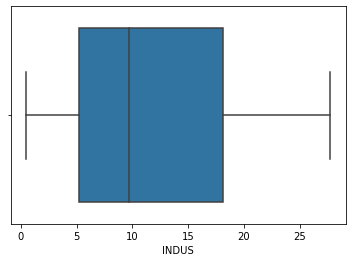

Distplot INDUS


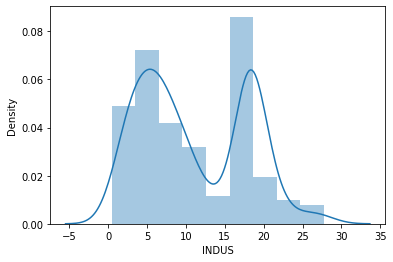

Boxplot CHAS


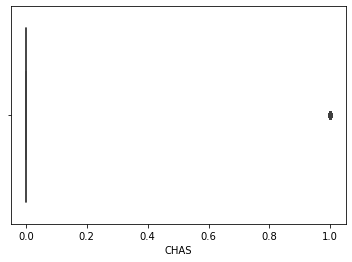

Distplot CHAS


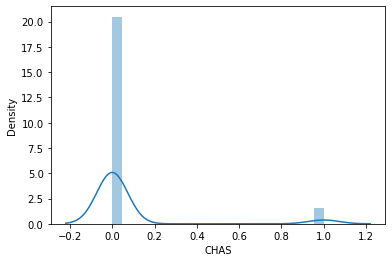

Boxplot NOX


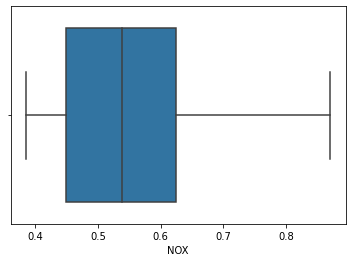

Distplot NOX


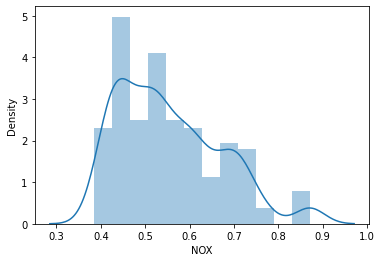

Boxplot RM


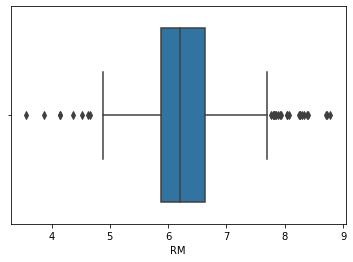

Distplot RM


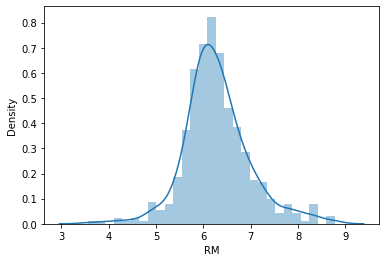

Boxplot AGE


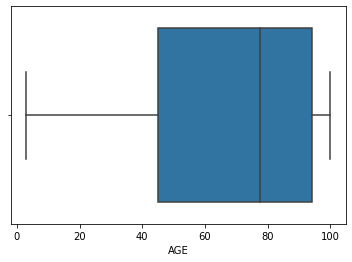

Distplot AGE


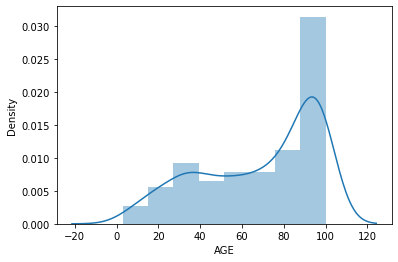

Boxplot DIS


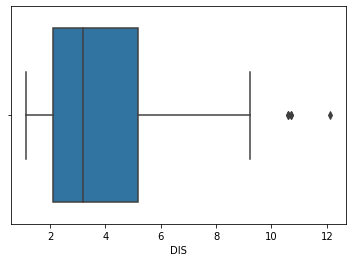

Distplot DIS


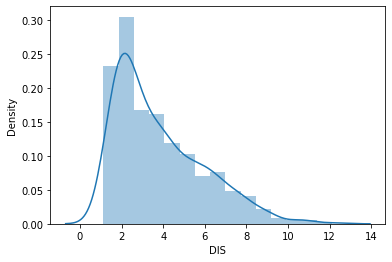

Boxplot RAD


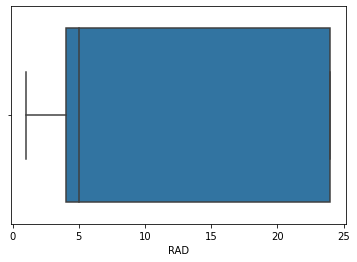

Distplot RAD


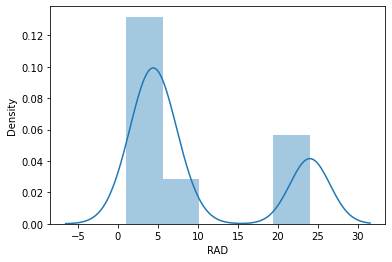

Boxplot TAX


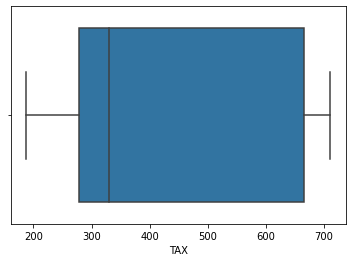

Distplot TAX


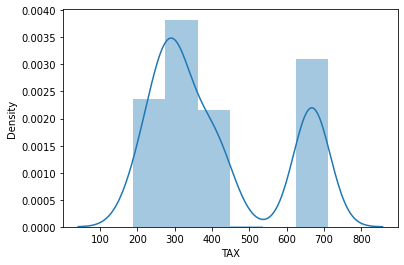

Boxplot PTRATIO


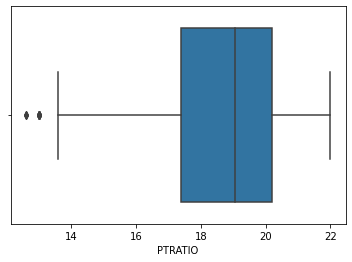

Distplot PTRATIO


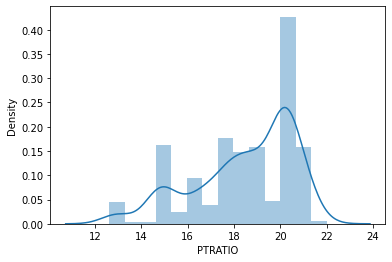

Boxplot B


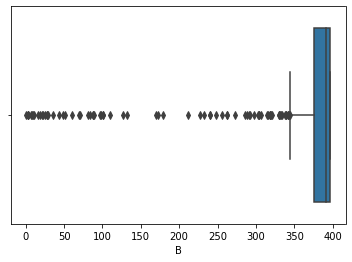

Distplot B


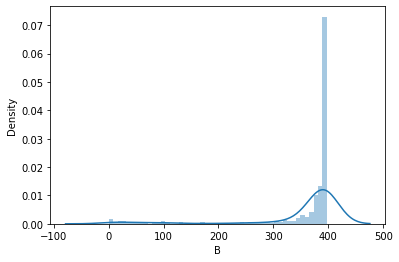

Boxplot LSTAT


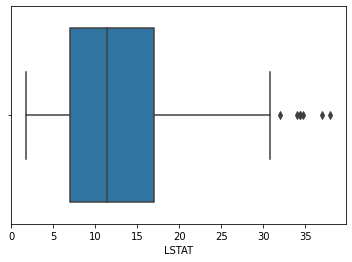

Distplot LSTAT


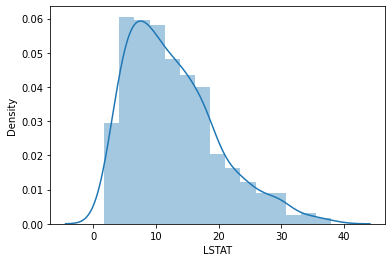

Boxplot MEDV


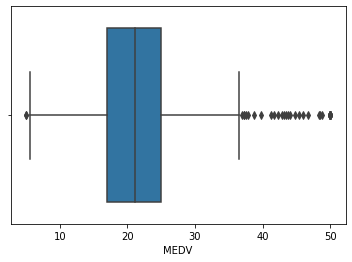

Distplot MEDV


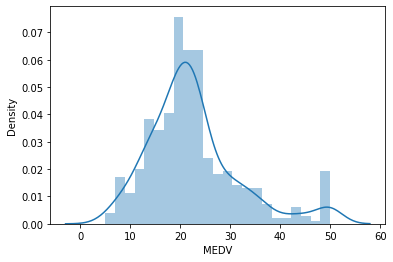

In [52]:
for name in houses.columns:
    print('\x1b[1;0346m'+'Boxplot {}'.format(name) +'\x1b[0m')
    sns.boxplot(x=houses['{}'.format(name)])
    plt.show()
    print('\x1b[1;0346m'+'Distplot {}'.format(name)+'\x1b[0m')
    sns.distplot(houses['{}'.format(name)])
    plt.show()

Посмотрим, какие значения являются выбросами для столбца 'CRIM' (Уровень преступности на душу населения по городам):

In [53]:
print(len(houses[houses['CRIM'] > 20]))
houses[houses['CRIM'] > 20].sort_values(['CRIM'], ascending=False)

18


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
380,88.9762,0.0,18.1,0,0.671,6.968,91.9,1.4165,24,666,20.2,396.90,17.21,10.4
418,73.5341,0.0,18.1,0,0.679,5.957,100.0,1.8026,24,666,20.2,16.45,20.62,8.8
405,67.9208,0.0,18.1,0,0.693,5.683,100.0,1.4254,24,666,20.2,384.97,22.98,5.0
410,51.1358,0.0,18.1,0,0.597,5.757,100.0,1.4130,24,666,20.2,2.60,10.11,15.0
414,45.7461,0.0,18.1,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0
404,41.5292,0.0,18.1,0,0.693,5.531,85.4,1.6074,24,666,20.2,329.46,27.38,8.5
398,38.3518,0.0,18.1,0,0.693,5.453,100.0,1.4896,24,666,20.2,396.90,30.59,5.0
427,37.6619,0.0,18.1,0,0.679,6.202,78.7,1.8629,24,666,20.2,18.82,14.52,10.9
413,28.6558,0.0,18.1,0,0.597,5.155,100.0,1.5894,24,666,20.2,210.97,20.08,16.3
417,25.9406,0.0,18.1,0,0.679,5.304,89.1,1.6475,24,666,20.2,127.36,26.64,10.4


Для сравнения:

In [54]:
houses.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Действительно, стоимость меньше, но не всегда. Например, четвертый по уровню преступности город имеет среднюю цену 15.0 тыс долл, в то время как соседние 5.0 и 7.0 соответственно. Далее стоимость тоже колеблется. Возможно, это выбросы, возможно, нет. В любом случае, удалить строки с такими значениями мы не можем, т.к. данных очень мало - всего 506 строк. 

In [55]:
print(len(houses[houses['ZN'] > 20]))
houses[houses['ZN'] > 20].sort_values(['ZN'], ascending=False)

101


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
57,0.01432,100.0,1.32,0,0.4110,6.816,40.5,8.3248,5,256,15.1,392.90,3.95,31.6
200,0.01778,95.0,1.47,0,0.4030,7.135,13.9,7.6534,3,402,17.0,384.30,4.45,32.9
204,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55,2.88,50.0
203,0.03510,95.0,2.68,0,0.4161,7.853,33.2,5.1180,4,224,14.7,392.78,3.81,48.5
199,0.03150,95.0,1.47,0,0.4030,6.975,15.3,7.6534,3,402,17.0,396.90,4.56,34.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.19133,22.0,5.86,0,0.4310,5.605,70.2,7.9549,7,330,19.1,389.13,18.46,18.5
53,0.04981,21.0,5.64,0,0.4390,5.998,21.4,6.8147,4,243,16.8,396.90,8.43,23.4
52,0.05360,21.0,5.64,0,0.4390,6.511,21.1,6.8147,4,243,16.8,396.90,5.28,25.0
51,0.04337,21.0,5.64,0,0.4390,6.115,63.0,6.8147,4,243,16.8,393.97,9.43,20.5


Здесь тоже 101 строчка как будто выбросы.По сути это 1/4 часть данных. 25% выбросить - это непозволительно, поэтому оставим пока как есть и попробуем обучить модели так.

Поэтому подготовим датафрейм для обучения:

In [56]:
features = houses.drop('MEDV', axis=1)
target = houses['MEDV']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.33, random_state=42)

### Шаг 2. Обучение моделей

Для начала запустим модель ***линейной регрессии***, чтобы нам знать, от чего отталкиваться:

In [57]:
lin_reg = LinearRegression().fit(features_train, target_train)
lin_predict = lin_reg.predict(features_test)
lin_rmse = np.sqrt(mean_squared_error(target_test, lin_predict)) 
print("RMSE for Linear Regression model: ", lin_rmse)

RMSE for Linear Regression model:  4.55236459846306


И для сравнения иерархическую древовидную модель ***дерево решений***:

In [58]:
tree = DecisionTreeRegressor(random_state=42).fit(features_train, target_train)
tree_predict = tree.predict(features_test)
tree_rmse = np.sqrt(mean_squared_error(target_test, tree_predict)) 
print("RMSE for Decision Tree model: ", tree_rmse)

RMSE for Decision Tree model:  4.338022949890013


А теперь запустим обучение всех выбранных нами 7 моделей в цикле. При этом с помощью метода GridSearcg переберем гиперпараметры и сравним результаты.  
Итак, метод ***Randomized Grid Search***:

In [59]:
%%time
models=[
      {'name':'Lr',"model":LinearRegression(), 'params':{'fit_intercept':['True', 'False'], 'normalize':['True', 'False'], 'positive':['True', 'False']}},  
      {'name':'Ls',"model": LassoCV()  , 'params':{'n_alphas':[10,50,100,150,200]}},
      {'name':'R',"model": Ridge(), 'params':{'alpha': [200, 230, 250,265, 270, 275, 290, 300, 500], 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}},
      {'name':'SVR',"model": SVR(), 'params':{'kernel': ('linear', 'rbf','poly'), 'C':[0.1,0.3,0.5,0.7,1,10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}},
      {'name':'RF',"model": RandomForestRegressor(), 'params':{'n_estimators':[10,25,50,100,150,200], 'criterion':['mse', 'mae'], 'max_depth':[3,5,7,9,11]}},
      {'name':'BR',"model": BayesianRidge(), 'params':{'n_iter':[100,200,300,400,500],'alpha_1': [1e-7, 1e-4, 1e-6], 'lambda_1':[1e-7, 1e-4, 1e-6], 'alpha_2': [1e-7, 1e-5, 1e-6], 'lambda_2':[1e-7, 1e-3, 1e-6]}},
      {'name':'DT',"model": DecisionTreeRegressor(), 'params':{'criterion':['mse', 'friedman_mse', 'mae', 'poisson'], 'max_depth':[3,5,7,9,11]}},
      {'name':'KN',"model": KNeighborsRegressor(), 'params':{'n_neighbors':list(range(1,30)),'weights': ['uniform', 'distance'], 'p':[1,2,3]}}
    

]

result=[]
for model in models:
    result.append((model['name'], RandomizedSearchCV(model['model'], model['params'], cv=10).fit(features_train, target_train)))

Wall time: 2min 36s


In [60]:
for r in result:
    print(r[0], r[1].best_score_, r[1].best_params_)

Lr 0.5183083207988842 {'positive': 'True', 'normalize': 'True', 'fit_intercept': 'True'}
Ls 0.6688036560858241 {'n_alphas': 10}
R 0.6619212832010376 {'solver': 'cholesky', 'alpha': 250}
SVR 0.7139618036662704 {'kernel': 'poly', 'gamma': 0.0001, 'epsilon': 0.2, 'C': 1}
RF 0.8165200086297727 {'n_estimators': 150, 'max_depth': 9, 'criterion': 'mse'}
BR 0.6835166979986137 {'n_iter': 400, 'lambda_2': 0.001, 'lambda_1': 1e-07, 'alpha_2': 1e-06, 'alpha_1': 1e-07}
DT 0.6585570708742926 {'max_depth': 9, 'criterion': 'mse'}
KN 0.4989568309652741 {'weights': 'distance', 'p': 2, 'n_neighbors': 6}


In [61]:
predict = []
for res in result:
    predict.append((res[0], res[1].best_estimator_.predict(features_test))) 

predict = []
predict.append(('LR', LinearRegression(positive=True, normalize=True, fit_intercept=True).fit(features_train, target_train).predict(features_test))) 
predict.append(('LS', LassoCV(n_alphas=10).fit(features_train, target_train).predict(features_test)))
predict.append(('R', Ridge(alpha=275, solver='cholesky').fit(features_train, target_train).predict(features_test)))
predict.append(('SVR', SVR(kernel='linear', gamma=1e-07, epsilon=0.2, C=0.7).fit(features_train, target_train).predict(features_test)))
predict.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=11, criterion='mse').fit(features_train, target_train).predict(features_test)))
predict.append(('BR', BayesianRidge(n_iter=100, lambda_2=0.001, lambda_1=1e-07, alpha_2=1e-07, alpha_1=0.0001).fit(features_train, target_train).predict(features_test))) 
predict.append(('DT', DecisionTreeRegressor(max_depth=7, criterion='friedman_mse').fit(features_train, target_train).predict(features_test)))
predict.append(('KN', KNeighborsRegressor(weights='distance', p=1, n_neighbors=6).fit(features_train, target_train).predict(features_test)))

In [62]:
for pred in predict:
    print("RMSE for {} model: {}".format(pred[0], np.sqrt(mean_squared_error(target_test, pred[1]))))

RMSE for Lr model: 5.693567664274963
RMSE for Ls model: 4.863948823087003
RMSE for R model: 4.9171766902950775
RMSE for SVR model: 4.130931383828808
RMSE for RF model: 3.3005639211818587
RMSE for BR model: 4.677390991082593
RMSE for DT model: 4.171197269159364
RMSE for KN model: 5.456200451938445


Подводим итоги: модель линейной регрессии показала несколько хуже результат, чем с параметрами по умолчанию. Рандомный перебор не улучшил работу модели. Зато дерево решений показало результат лучше. Что же до остальных моделей - лидирует RandomForestRegressor.

Теперь попробуем метод ***Байесовской оптимизации***:

Напишем функцию по созданию пространства признаков:

In [63]:
def find_search_space(model):
    search_space = []
    
    # задаем label
    label = list(model['params'].keys())
    
    # задаем параметры, которые будем перебирать
    par = list(model['params'].values())
    
    for l in range(len(label)):
        search_space.append(hp.choice(label=label[l], options=par[l]))
    return search_space

И функцию, которую будем оптимизировать. Она принимает на вход гиперпараметры, модель и данные, после чего возвращает точность на кросс-валидации:

In [64]:
def objectives(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами
    
    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 
                  
    # задаём модели требуемые параметры    
    pipeline.set_params()
    
 
    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    
    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': score.mean(), 'params': params, 'status': STATUS_OK}

Выведем порядок моделей для себя еще раз:

In [65]:
for i in range(len(models)):
    print(i, models[i]['model'])

0 LinearRegression()
1 LassoCV()
2 Ridge()
3 SVR()
4 RandomForestRegressor()
5 BayesianRidge()
6 DecisionTreeRegressor()
7 KNeighborsRegressor()


Теперь считаем:

In [66]:
best_par = []
for i in range(len(models)):
    trials = Trials()
    best_par.append((models[i]['name'], fmin( 
          # функция для оптимизации  
            fn=partial(objectives, pipeline=models[i]['model'], X_train=features_train, y_train=target_train),
          # пространство поиска гиперпараметров  
            space=find_search_space(models[i]),
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )))
best_par

100%|██████████| 40/40 [00:01<00:00, 22.55trial/s, best loss: -49.67545764705883]


[('Lr', {'fit_intercept': 0, 'normalize': 0, 'positive': 0}),
 ('Ls', {'n_alphas': 4}),
 ('R', {'alpha': 7, 'solver': 4}),
 ('SVR', {'C': 2, 'epsilon': 0, 'gamma': 0, 'kernel': 0}),
 ('RF', {'criterion': 0, 'max_depth': 1, 'n_estimators': 2}),
 ('BR',
  {'alpha_1': 2, 'alpha_2': 2, 'lambda_1': 0, 'lambda_2': 0, 'n_iter': 4}),
 ('DT', {'criterion': 3, 'max_depth': 1}),
 ('KN', {'n_neighbors': 28, 'p': 0, 'weights': 0})]

Отлично!
Переходим к обучению:

In [67]:
lr = LinearRegression(fit_intercept=True, normalize=True, positive=True).fit(features_train, target_train)  
ls =  LassoCV(n_alphas=200).fit(features_train, target_train)  
rd =  Ridge(alpha=300, solver='sag').fit(features_train, target_train)  
svr =  SVR(C=2, epsilon=0.1, gamma=1e-7, kernel='linear').fit(features_train, target_train)  
rfr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=3).fit(features_train, target_train)  
br = BayesianRidge(n_iter=500, alpha_1=1e-6, lambda_1=1e-7, alpha_2=1e-6, lambda_2=1e-7).fit(features_train, target_train)  
dtr = DecisionTreeRegressor(criterion='poisson', max_depth=7).fit(features_train, target_train)  
knn = KNeighborsRegressor(n_neighbors=29, weights='uniform', p=1).fit(features_train, target_train)  

In [68]:
pred = []
for i in [lr, ls, rd, svr, rfr, br, dtr, knn]:
    pred.append((i, i.predict(features_test)))

In [69]:
for n, p in zip(models, pred):
    print("RMSE for {} model: {}".format(n['name'], np.sqrt(mean_squared_error(target_test, p[1]))))

RMSE for Lr model: 5.693567664274963
RMSE for Ls model: 4.863948823087003
RMSE for R model: 5.037702762603614
RMSE for SVR model: 5.0153725106921305
RMSE for RF model: 3.827660329466225
RMSE for BR model: 4.677394609449379
RMSE for DT model: 7.252922113615802
RMSE for KN model: 6.75766891240665


Итак, подводя итог, можно заметить, что метод GridSearch лучше справился с задачей перебора параметров, хоть и дольше по времени.

### Выводы
Таким образом, целью данной работы было обучить минимум 7 любых регрессионных моделей, а затем перебрать гиперпараметры для оптимизации работы моделей.  
В ходе работы были сделаны следующие шаги:
- Первый шаг - загрузка и изучение данных. На этом этапе мы проанализировали данные и выявили некоторые аномалии.
- Второй шаг - обучение моделей, перебор гиперпараметров и сравнение результатов. В ходе данного шага проведено обучение моделей:
        - линейной регрессии,
        - LassoCV, 
        - Ridge, 
        - SVR, 
        - случайного леса, 
        - BayesianRidge, 
        - дерева решений, 
        - метода ближайших соседей.  
        
В начале данного шага были обучены 2 модели (линейная регрессия и дерево решений). Они показали схожий результат. Тогда с помощью метода ***Randomized Grid Search*** мы перебрали гиперпараметры и обучили модели. Наилучший результат показал случайный лес.   

Далее перебор гиперпараметров для моделей был произведен с помощью ***Байесовской оптимизации***. Итогом стал выбор параметров, несколько отличных от вывода Randomized Grid Search. После обучения моделей оказалось, что результат работы Randomized Grid Search несколько лучше, чем у Байесовской оптимизации. Тем не менее, стоит сказать, что результат оказался таковым именно в данной ситуации, на данном датасете.  
В любом случае, модель случайного леса показала наилучший результат при обеих оптимизациях.  
Цель работы достигнута.